In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import torch
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image

# Define the directory paths
test_image_path_1 = "/kaggle/input/validation-edited/val/nofire/Smoke_confounding_elements/30831368247_d7a64725ef_o.jpg"
test_image_path_2 = "/kaggle/input/validation-edited/val/nofire/Forested_areas_without_confounding_elements/23907524626_fe34fb151b_o.jpg"
test_image_path_3 = "/kaggle/input/validation-edited/val/nofire/Fire_confounding_elements/20936712539_dc5a8e8230_o.jpg"
test_image_path_4 = "/kaggle/input/validation-edited/val/fire/Smoke_from_fires/20680295374_7af01a40b6_o.jpg"
test_image_path_5 = "/kaggle/input/validation-edited/val/fire/Both_smoke_and_fire/21195748828_52755e4eb7_o.jpg"
test_image_path_6 = "/kaggle/input/test-image/download_fire.jpeg"



# ViT Feature Extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

# label_mapping = {
#             "Smoke_confounding_elements": 0,
#             "Forested_areas_without_confounding_elements": 1,
#             "Fire_confounding_elements": 2,
#             "Smoke_from_fires": 3,
#             "Both_smoke_and_fire": 4,
#         }

2024-04-25 06:36:09.311549: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 06:36:09.311644: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 06:36:09.477200: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [2]:
# Loading pre-trained ViT models
binary_model = ViTForImageClassification.from_pretrained('/kaggle/input/capstone-models/Binary_VIT_10epochs/Binary_VIT_10epochs')
fire_subclass_model = ViTForImageClassification.from_pretrained('/kaggle/input/capstone-models/fire_subclass_model_VIT/fire_subclass_model_VIT')
nofire_subclass_model = ViTForImageClassification.from_pretrained('/kaggle/input/10epochs-nofiremodel/nofire_subclass_model_VIT_10epochs')

Test Image 1 
 Binary Prediction: No fire
Subclass Prediction: 0

Test Image 2  
 Binary Prediction: No fire
Subclass Prediction: 1

Test Image 3 
 Binary Prediction: No fire
Subclass Prediction: 2

Test Image 4 results 
 Binary Prediction: Fire
Subclass Prediction: 3

Test Image 5 
 Binary Prediction: Fire
Subclass Prediction: 4

Test Image 6 
 Binary Prediction: Fire
Subclass Prediction: 4


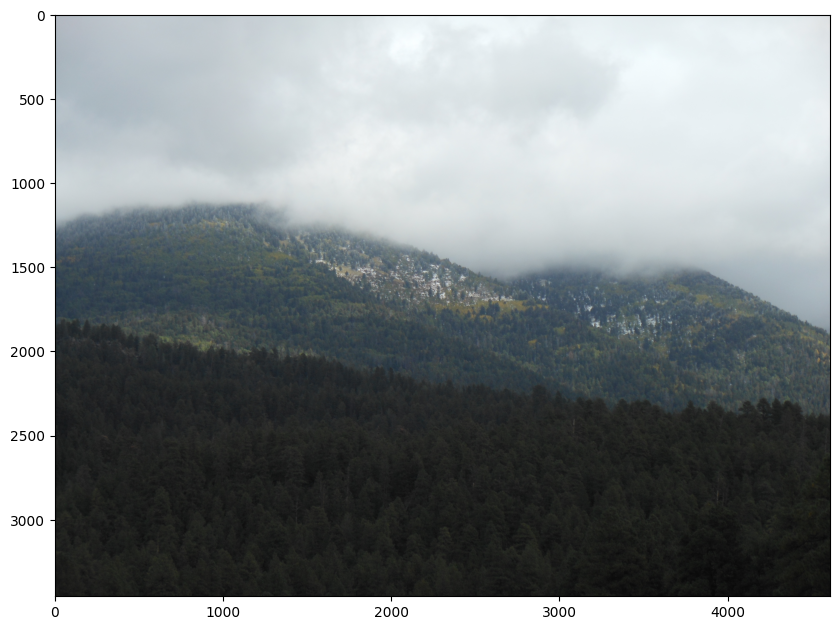

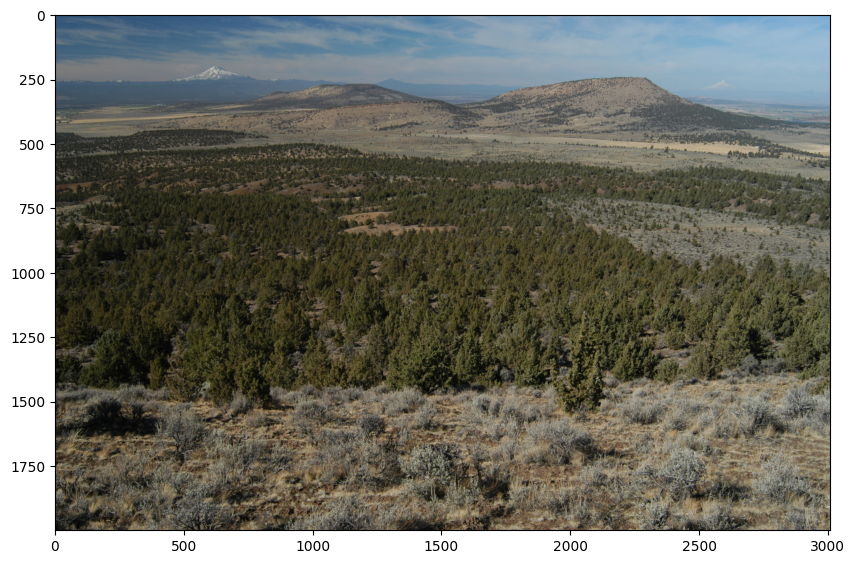

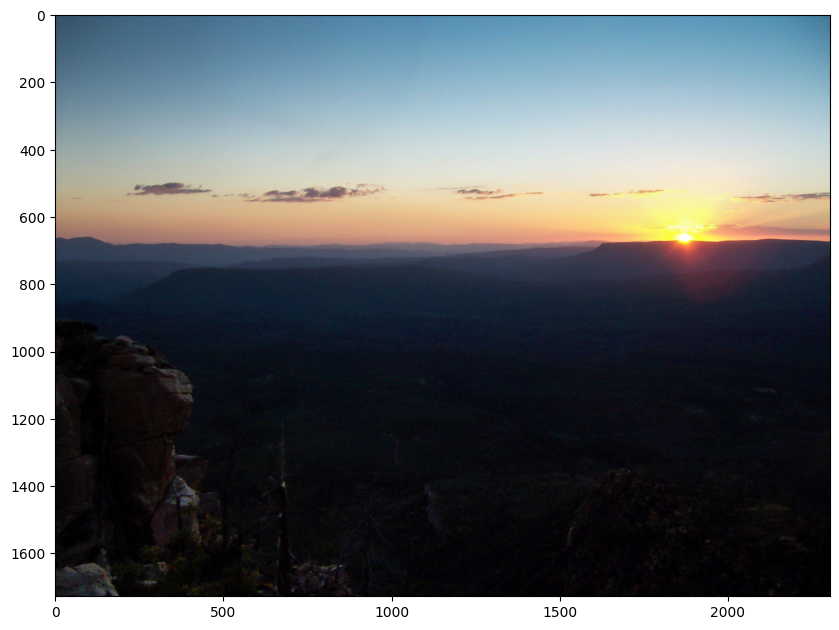

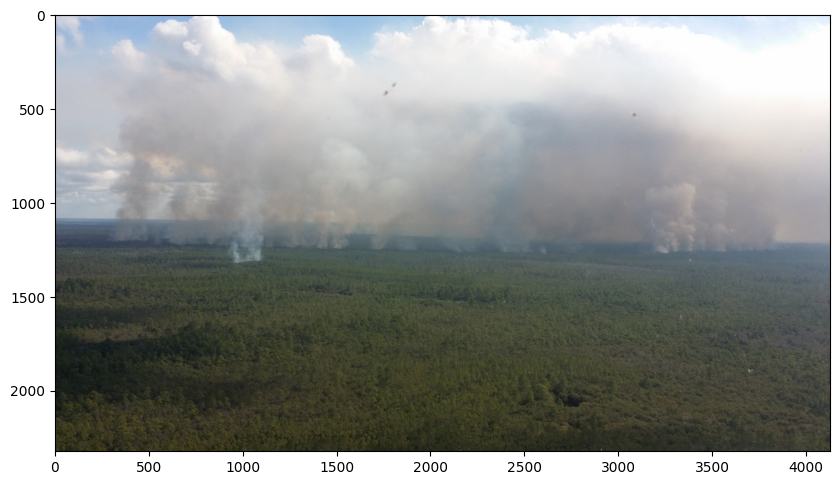

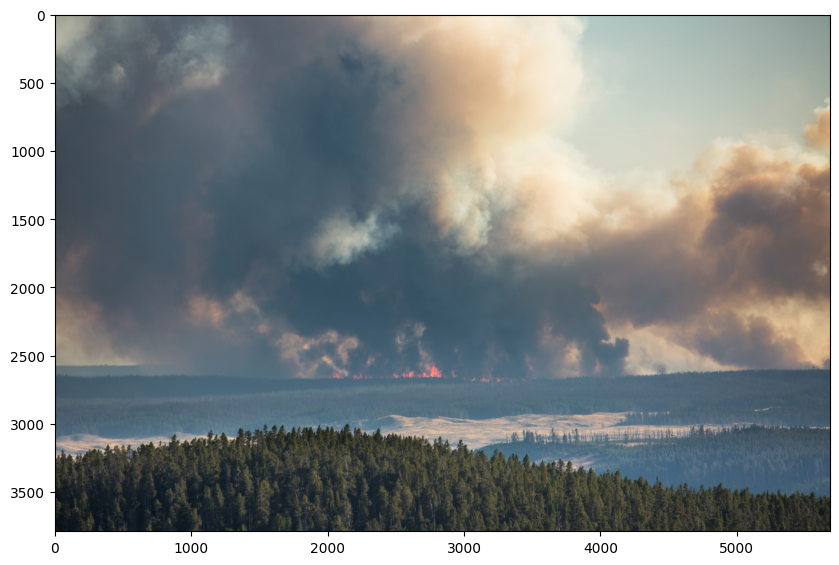

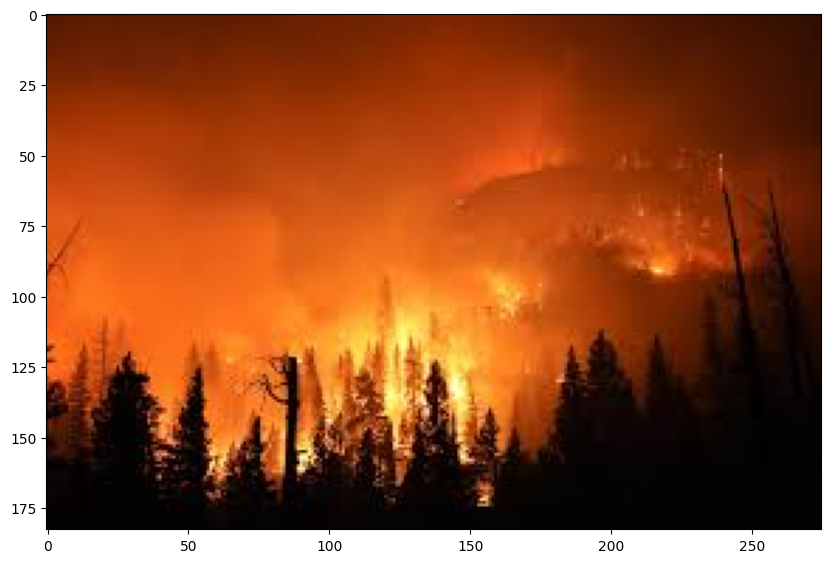

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Cascading model function for a single image
def cascading_model(binary_model, nofire_subclass_model, fire_subclass_model, image_path):
    # Preprocess the input image
    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    image = feature_extractor(images=image, return_tensors="pt")["pixel_values"]
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    binary_model.eval()
    nofire_subclass_model.eval()
    fire_subclass_model.eval()
    

    with torch.no_grad():
        # Pass data through binary classifier
        binary_outputs = binary_model(image.to(device))
        binary_prediction = torch.argmax(binary_outputs.logits, dim=1).item()

        # Pass data through corresponding subclass classifier
        if binary_prediction == 0:  # No fire
            subclass_outputs = nofire_subclass_model(image.to(device))
            subclass_prediction = torch.argmax(subclass_outputs.logits, dim=1).item()
        else:  # Fire
            subclass_outputs = fire_subclass_model(image.to(device))
            subclass_prediction = torch.argmax(subclass_outputs.logits, dim=1).item()
            subclass_prediction += 3
        
        

    return binary_prediction, subclass_prediction

# Get predictions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

binary_prediction, subclass_prediction = cascading_model(binary_model.to(device), nofire_subclass_model.to(device), fire_subclass_model.to(device), test_image_path_1)

# Print predictions
print("Test Image 1 \n Binary Prediction:", "No fire" if binary_prediction == 0 else "Fire")
print("Subclass Prediction:", subclass_prediction)

binary_prediction, subclass_prediction = cascading_model(binary_model.to(device), nofire_subclass_model.to(device), fire_subclass_model.to(device), test_image_path_2)

print("\nTest Image 2  \n Binary Prediction:", "No fire" if binary_prediction == 0 else "Fire")
print("Subclass Prediction:", subclass_prediction)

binary_prediction, subclass_prediction = cascading_model(binary_model.to(device), nofire_subclass_model.to(device), fire_subclass_model.to(device), test_image_path_3)

# Print predictions
print("\nTest Image 3 \n Binary Prediction:", "No fire" if binary_prediction == 0 else "Fire")
print("Subclass Prediction:", subclass_prediction)

binary_prediction, subclass_prediction = cascading_model(binary_model.to(device), nofire_subclass_model.to(device), fire_subclass_model.to(device), test_image_path_4)

print("\nTest Image 4 results \n Binary Prediction:", "No fire" if binary_prediction == 0 else "Fire")
print("Subclass Prediction:", subclass_prediction)

binary_prediction, subclass_prediction = cascading_model(binary_model.to(device), nofire_subclass_model.to(device), fire_subclass_model.to(device), test_image_path_5)


print("\nTest Image 5 \n Binary Prediction:", "No fire" if binary_prediction == 0 else "Fire")
print("Subclass Prediction:", subclass_prediction)

binary_prediction, subclass_prediction = cascading_model(binary_model.to(device), nofire_subclass_model.to(device), fire_subclass_model.to(device), test_image_path_6)


print("\nTest Image 6 \n Binary Prediction:", "No fire" if binary_prediction == 0 else "Fire")
print("Subclass Prediction:", subclass_prediction)
